# Análise dos Resultados da Otimização dos Parâmetros

# Índice:
   * [Descrição](#description)
      * [Objetivos](#goals)
   * [Imports](#imports)
   * [Recuperação dos Dados do MLFlow](#recover)
       *[Modelos](#recoverModels)
       *[Resultados](#recoverResults)
   * [Análise](#analysis)
      * [Plot de Coordenadas Paralelas](#parallel)
      * [Plos de Desemepenho](#plotScore)
      * [Estrutura das Árvores](#treeStructure)
      * [Importância das Características](#featureImportance)
      * [p-valor](#pvalue)

In [1]:
%pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 1.3 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 8.7 MB/s eta 0:00:00:00:010:01
Note: you may need to restart the kernel to use updated packages.


## Descrição<a class="anchor" id="description"></a>

Esse notebook recupera os dados da busca de híper-parâmetros e analisa os resultados. São analisados o desempenho dos modelos nos testes, as estruturas de árvores com diferentes parâmetros e a importância das características utilizadas.

### Objetivos<a class="anchor" id="goals"></a>
   * Entender como os parâmetros de uma árvore de decisão influenciam sua estrutura e no seu desempenho no problema.
   * Apontar parâmetros ideais para o modelo baseado árvore de decisão para o problema.


## Imports

In [2]:
from time import time
import tempfile
import os

import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.tracking import MlflowClient
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID
from mlflow.entities import ViewType
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl


## Conexão com o MLflow

Para exeutar a conexão, é necessário passar o endereço de IP da máquina que hospeda o container que está rondando o MLflow. No bash, isso pode ser feito com $ip r.

In [3]:
def connectMLFlow(MLFlowAddr):
    client = MlflowClient(tracking_uri=MLFlowAddr)
    mlflow.set_tracking_uri(MLFlowAddr)
    return client

In [4]:
client = connectMLFlow("http://172.27.0.1:5000")

In [5]:
experiments =mlflow.get_experiment_by_name("ModelsSearch")
Treeexperiments =mlflow.get_experiment_by_name("HiperParameter Search")
Linearexperiments = mlflow.get_experiment_by_name("Simple Model")
VGGexperiments = mlflow.get_experiment_by_name("VGG16 Model")
VGGexperiments

<Experiment: artifact_location='s3://mlflow/77', experiment_id='77', lifecycle_stage='active', name='VGG16 Model', tags={}>

In [6]:
runs = mlflow.search_runs(experiments.experiment_id, output_format = "list")
treeRuns = mlflow.search_runs(Treeexperiments.experiment_id, output_format = "list")
linearRuns = mlflow.search_runs(Linearexperiments.experiment_id, output_format = "list")
vggRuns = mlflow.search_runs(VGGexperiments.experiment_id, output_format = "list")

In [7]:
run_names = [run.data.tags['mlflow.runName'] for run in runs]
treeRun_names = [run.data.tags['mlflow.runName'] for run in treeRuns]
linearRun_names = [run.data.tags['mlflow.runName'] for run in linearRuns]
vggRun_names = [run.data.tags['mlflow.runName'] for run in vggRuns]
vggRun_names

['PCA', 'PCA', 'LinearRegression']

In [8]:
picked_runs = [linearRuns[0],treeRuns[0],runs[4],runs[5],runs[0],vggRuns[2], vggRuns[0]]

In [9]:
picked_runs_names = [run.data.tags['mlflow.runName'] for run in picked_runs[0:5]]

picked_runs_names.append("VGG16 Linear Regression")
picked_runs_names

['LinearRegression',
 'DecisionTree GridSearch',
 'KNeighbors RandomSearch',
 'RandomForest RandomSearch',
 'NeuralNetwork RandomSearch',
 'VGG16 Linear Regression']

## Funções Auxiliares

Nesta parte são defenidas funções para carregar os dados do MLflow, para imprimir esses dados, para carregá-los em um DataFrame, para selecioná-los e para plotar os resultados. 

In [10]:
def recoverSearchRun(run):
    #test_random_state = int(run.data.tags["test_random_state"])
    #test_size = float(run.data.tags["test_size"])
    #split_params = [test_random_state, test_size]
    
    #model_params = eval(run.data.params["param_distributions"])
    
    uri = run.info.artifact_uri
    model = mlflow.sklearn.load_model(uri+"/model")
    
    #results = recoverResultsCSV(uri+"/cv_results")
    
    return  model 
    
    

In [11]:
models = []
for run in picked_runs:
    model= recoverSearchRun(run)
    models.append(model)

In [12]:
models

[LinearRegression(),
 DecisionTreeRegressor(max_depth=9, min_samples_leaf=35, min_samples_split=125,
                       random_state=10),
 KNeighborsRegressor(leaf_size=5, n_neighbors=95),
 RandomForestRegressor(max_depth=10, max_leaf_nodes=550, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=151, random_state=10),
 MLPRegressor(alpha=0.01, hidden_layer_sizes=(20, 15), max_iter=1500,
              random_state=10, solver='lbfgs'),
 LinearRegression(),
 PCA(n_components=300)]

In [13]:
objects = []
with (open("../extracao/keras.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pkl.load(openfile))
        except EOFError:
            break


In [14]:
def read_data(url):
    return pd.read_csv(os.path.abspath(url))
df = read_data("../extracao/datanov2.csv")
def getXy(df):
    r_state = 15
    df = shuffle(df, random_state=r_state)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    return X, y
r_state = 10
X, y = getXy(df)
X_train, X_test, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=10
)


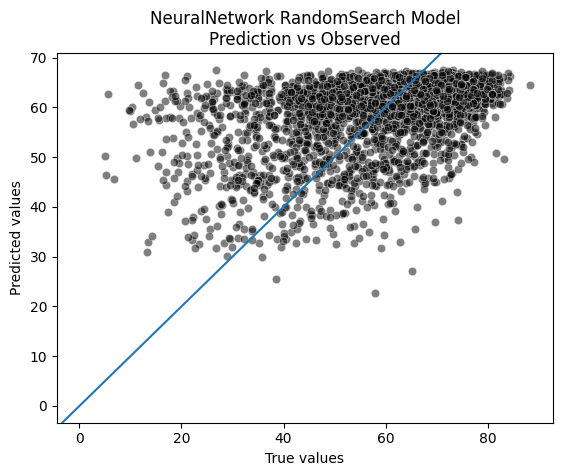

In [16]:
predicted_actual = {
    "True values": y_val, "Predicted values": models[4].predict(X_test)}
predicted_actual = pd.DataFrame(predicted_actual)

sns.scatterplot(data=predicted_actual,
                x="True values", y="Predicted values",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
a_ = plt.title(f"{picked_runs_names[4]} Model\nPrediction vs Observed")

In [17]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [18]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [20]:
gridPredictionVal = models[1].predict(X_test)
gridPredictionTrain = models[1].predict(X_train)

rmse, mae, r2 = eval_metrics(y_train, gridPredictionTrain)
print (f"{picked_runs_names[1]}: Desempenho no conjunto de Treino\nrmse:{rmse}    mae:{mae}    r2:{r2}")

rmse, mae, r2 = eval_metrics(y_val, gridPredictionVal)
print (f"{picked_runs_names[1]}: Desempenho no conjunto de Testes (Validação)\nrmse:{rmse}    mae:{mae}    r2:{r2}")


DecisionTree GridSearch: Desempenho no conjunto de Treino
rmse:12.522044099688351    mae:9.710029222228924    r2:0.3509999859058073
DecisionTree GridSearch: Desempenho no conjunto de Testes (Validação)
rmse:13.09465127294294    mae:10.139468613569441    r2:0.25446618941123134


In [22]:
maes = []
for model in models[0:5]:
    predictionVal = model.predict(X_test)
    rmse, mae, r2 = eval_metrics(y_val, predictionVal)    
    maes.append(mae)

In [24]:
pca = models[-1]

In [26]:
XYGG = pd.DataFrame([o[1] for o in objects])


In [27]:
yYGG = pd.DataFrame([o[2] for o in objects])

In [28]:
X_trainYGG, X_testYGG, y_trainYGG, y_testYGG = train_test_split(
    XYGG, yYGG, test_size=0.3, random_state=10
)
maes.append(mae)

In [31]:
y_pred_testYGG2 = models[-2].predict(pca.transform(X_testYGG))
rmse, mae, r2 = eval_metrics(y_testYGG, y_pred_testYGG2)
print (f"Desempenho no conjunto de Testes (Validação)\nrmse:{rmse}    mae:{mae}    r2:{r2}")


Desempenho no conjunto de Testes (Validação)
rmse:11.042398641960693    mae:8.611119238933064    r2:0.4852722773374224


In [34]:
mean = y_val.mean()
x = np.full((3022,), mean)
x.shape

rmse, mae, r2 = eval_metrics(y_val, x)
print (f"Desempenho no conjunto de Testes (Validação)\nrmse:{rmse}    mae:{mae}    r2:{r2}")

maes.append(mae)

Desempenho no conjunto de Testes (Validação)
rmse:15.165623330187778    mae:12.226496572317142    r2:0.0


In [35]:
maes

[10.78393282690518,
 10.139468613569441,
 10.966711800130652,
 9.81325597441602,
 10.709067016458425,
 8.611119238933064,
 12.226496572317142]

In [30]:
y_pred_testYGG = models[-2].predict(pca.transform(X_testYGG))


Desempenho no conjunto de Testes (Validação)
rmse:11.042398641960693    mae:8.611119238933064    r2:0.4852722773374224
Desempenho no conjunto de Treino
rmse:10.771913154765034    mae:8.407681787701375    r2:0.5136587006516755


In [36]:
y_testYGG = y_testYGG.values


In [22]:
X_testYGG.shape

(3022, 4096)

In [37]:
predicted_actualYGG = {
        "True values": y_testYGG.flatten(), "Predicted values": y_pred_testYGG.flatten()}
predicted_actualYGG = pd.DataFrame(predicted_actualYGG)

predicted_actualYGG


,True values,Predicted values
0,57.841743,71.404083
1,57.228155,61.128090
2,30.796117,52.555897
3,58.957983,64.888565
4,64.675000,66.071930
...,...,...
3017,64.027027,59.188881
3018,62.641509,67.533112
3019,60.608108,62.861763
3020,67.308411,69.656448


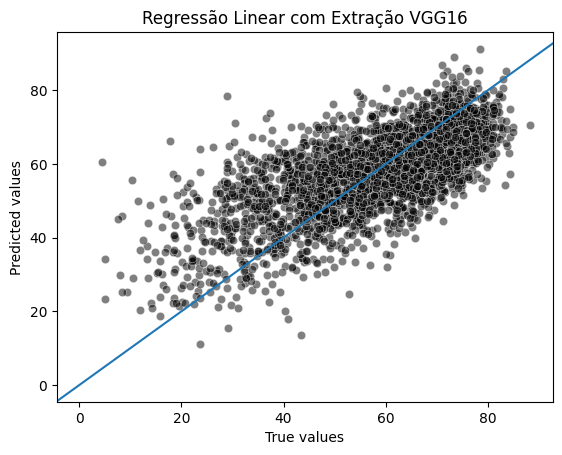

In [38]:
sns.scatterplot(data=predicted_actualYGG,
                x="True values", y="Predicted values",
                color="black", alpha=0.5)#,ax=axs[2][1])
plt.axline((0, 0), slope=1, label="Perfect fit")
_t = plt.title("Regressão Linear com Extração VGG16")

### Plots de Desempenho por Parâmetros <a class ="anchor" id="plotScore"></a>

Nessa seção estão os gráficos do desempenho do modelo por cada parâmetro, com o total de 4 plots.

In [39]:
picked_runs_names.append("Constant Model")

In [40]:
picked_runs_names

['LinearRegression',
 'DecisionTree GridSearch',
 'KNeighbors RandomSearch',
 'RandomForest RandomSearch',
 'NeuralNetwork RandomSearch',
 'VGG16 Linear Regression',
 'Constant Model']

In [41]:
performance_data = {"Models":picked_runs_names,"Mean Absolute Error":maes}


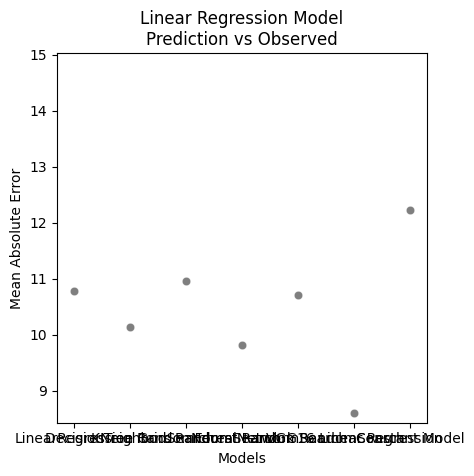

In [42]:
sns.scatterplot(data=performance_data,
                x="Models", y="Mean Absolute Error",
                color="black", alpha=0.5)
plt.axis('square')
_ = plt.title("Linear Regression Model\nPrediction vs Observed")

In [26]:
def plot_param_r2(df,param,ax):
    min_samples_group = df.groupby([param], as_index=False)['mean_test_r2'].mean()

    #plt.figure()
    ax.plot(min_samples_group[param],min_samples_group["mean_test_r2"])
    ax.set(xlabel=param, ylabel="r2", title=param)


    #plt.show()


In [45]:
def plot_predicted(model, ax):
    predicted_actual = {
        "True values": y_val, "Predicted values": model.predict(X_test)}
    predicted_actual = pd.DataFrame(predicted_actual)

    sns.scatterplot(data=predicted_actual,
                    x="True values", y="Predicted values",
                    color="black", alpha=0.5)#, ax=ax)
    ax.axline((0, 0), slope=1, label="Perfect fit")
    ax.axis('square')
    #_t = ax.title(title)
    #ax.title("Decision Tree Model\nPrediction vs Observed")

[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]]


(-4.419444444444445, 95.9962919447157, -4.564351654052735, 95.85138473510742)

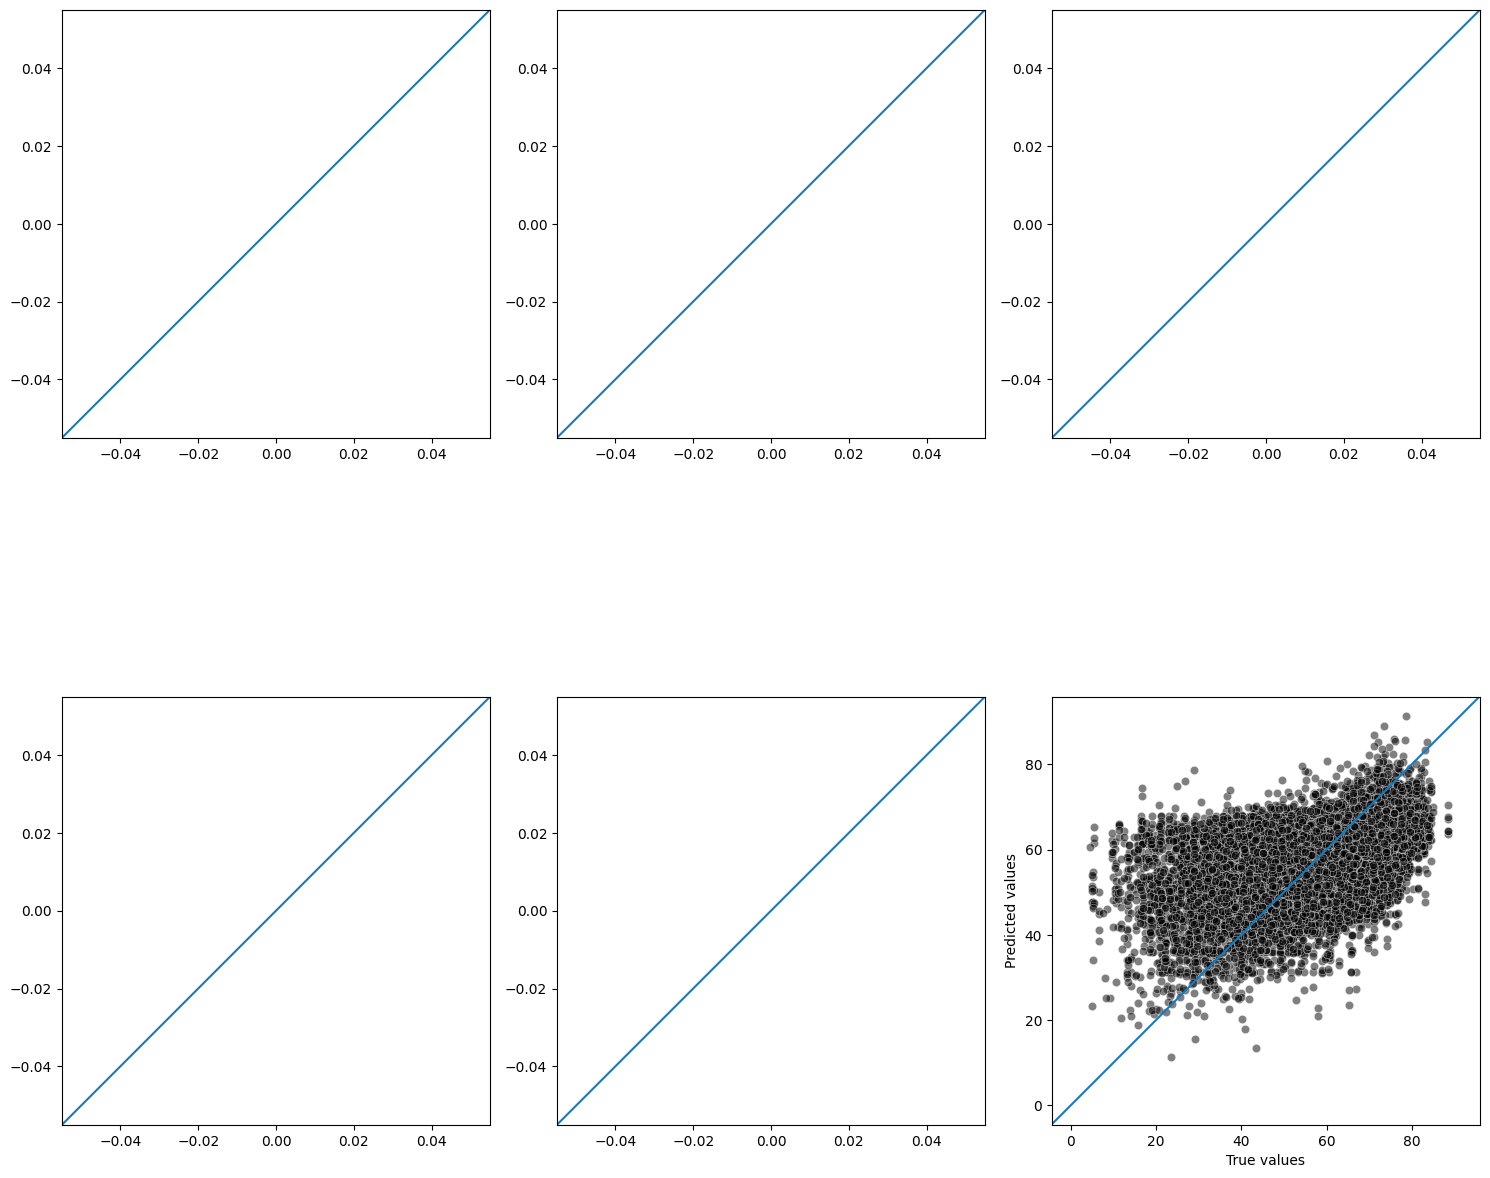

In [48]:
plot, axs = plt.subplots(2,3,figsize=(15, 15))
print (axs)
i = 0
j = 0

for model in models[0:5]:
    plot_predicted(model, axs[i][j])
    i+=1
    if i == 2:
        i = 0
        j += 1
#plt.subplots_adjust(bottom=0.1, right=1.8, top=2.5)
plot.tight_layout()
#axs[0].plot(x,y)
#plot_param_r2(df, "param_max_depth",axs[1])


sns.scatterplot(data=predicted_actualYGG,
                x="True values", y="Predicted values",
                color="black", alpha=0.5,ax=axs[1][2])
plt.axline((0, 0), slope=1, label="Perfect fit")

axs[1][2].axis('square')

In [ ]:
['LinearRegression',
 'DecisionTree GridSearch',
 'KNeighbors RandomSearch',
 'RandomForest RandomSearch',
 'NeuralNetwork RandomSearch',
 'LinearRegression',
 'PCA']

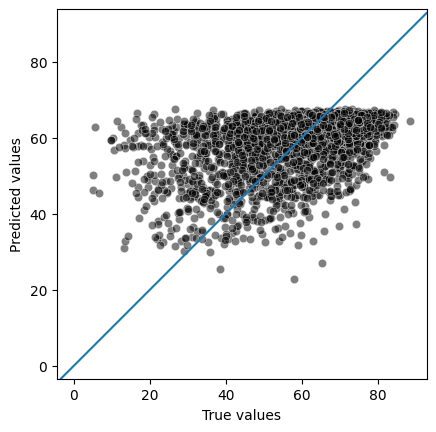

In [47]:
  plot_predicted(models[4], plt)

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]
dict_keys(['max_depth', 'min_samples_split', 'min_samples_leaf', 'n_estimators', 'max_leaf_nodes'])


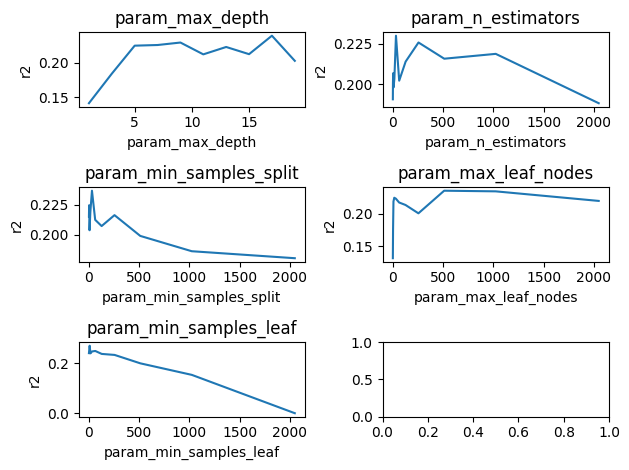

In [94]:
plot, axs = plt.subplots(3,2)
print (axs)
i = 0
j = 0
print (model_params.keys())
for name in model_params.keys():
    plot_param_r2(results, "param_" + name, axs[i][j])
    i+=1
    if i == 3:
        i = 0
        j = 1
#plt.subplots_adjust(bottom=0.1, right=1.8, top=2.5)
plot.tight_layout()
#axs[0].plot(x,y)
#plot_param_r2(df, "param_max_depth",axs[1])

Analisando os plots observa-se que o a altura da arvore é o príncipal fator para o desempenho do modelo, com alturas de 1 e 3 com os desempenhos mais negativos. Também é possível observar que o mínimo de folhas maior que 450 resulta em desempenhos piores do que os de uma árvore de altura máxima 5. Isso faz sentido pois com esse mínimo de amostras por folha, para o tamanho do set de treino (aproximadamente 6 mil), a altura resultante é no máximo 6 (uma árvore completa de tamanho 5 teria 4000 amostras).

### Plot das Previsões vs Valores Verdadeiros

In [166]:
def read_data(url):
    return pd.read_csv(os.path.abspath(url))

In [169]:
df = read_data("../extracao/datanov2.csv")

In [176]:
def getXy(df):
    r_state = 15
    df = shuffle(df, random_state=r_state)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    return X, y
r_state = 12
X, y = getXy(df)
X_train, X_test, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=10
)


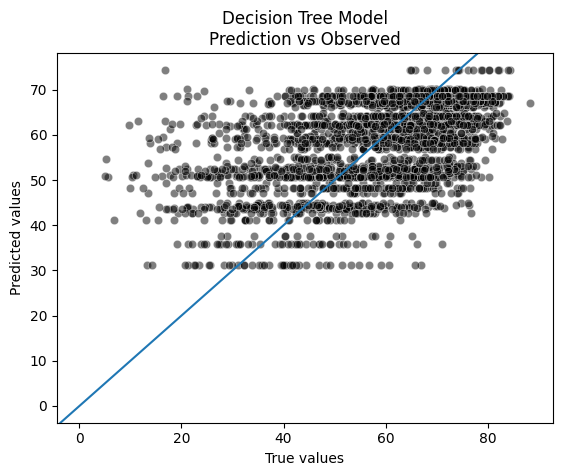

In [177]:
predicted_actual = {
    "True values": y_val, "Predicted values": model.predict(X_test)}
predicted_actual = pd.DataFrame(predicted_actual)

sns.scatterplot(data=predicted_actual,
                x="True values", y="Predicted values",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
a_ = plt.title("Decision Tree Model\nPrediction vs Observed")

## Importância das Características <a class="anchor" id="featureimportance"></a>

A importância das características é calculadas com o índice gini.

In [164]:
model.feature_importances_

array([0.02786052, 0.0282795 , 0.56332204, 0.15069145, 0.04374013,
       0.18610636])